# Processing Data Annotation

In [78]:
import os
import shutil
import glob
from tqdm.auto import tqdm
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt

## 1. 10% Data from 5 Classes

In [2]:
os.chdir('../')
annot_data_dir = 'raw_data/annot_data'
classes5_10percent_dirpath = 'raw_data/annot_data/5classes_10percent'

In [3]:
# list of 5 classes
classes5_list = ['chicken_curry', 'chocolate_cake', 'hamburger', 'pizza', 'ramen']
classes5_list

['chicken_curry', 'chocolate_cake', 'hamburger', 'pizza', 'ramen']

In [4]:
# Extracting the zip file
if not os.path.exists(classes5_10percent_dirpath):
    shutil.unpack_archive('raw_data/annot_data/5classes_10percent_annot.zip', 'raw_data/annot_data/5classes_10percent', 'zip')

### Converting and Visualizing on the Demo Annotation 

In [5]:
demo_img_file = 'raw_data/annot_data/5classes_10percent/JPEGImages/train/chicken_curry/221895.jpg'
demo_annot_file = 'raw_data/annot_data/5classes_10percent/SegmentationClass/train/chicken_curry/221895.png'

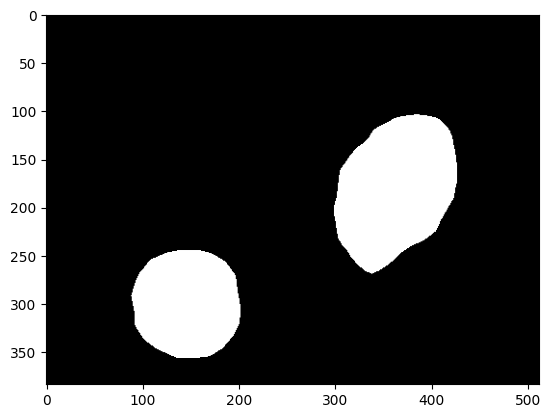

In [6]:
# Reading a demo annot file
mask = cv2.imread(demo_annot_file, cv2.IMREAD_GRAYSCALE)
_, mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)
H, W = mask.shape

# Visualizing the mask image
plt.imshow(mask, 'gray')

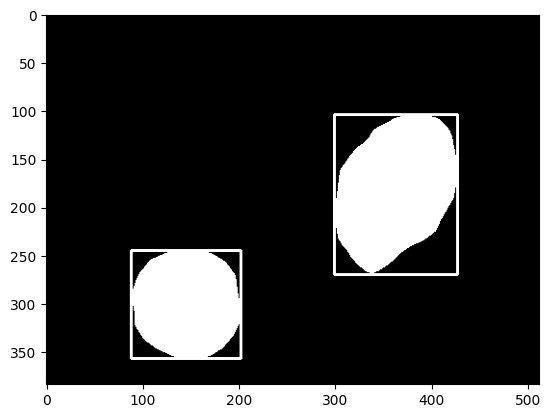

In [7]:
# Getting the contours of the mask image
contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Visualizing the contours
a = []
for i in contours:
      a.append(cv2.boundingRect(i))
img = np.zeros((H, W))
cv2.drawContours(img, contours, -1, (255, 255, 255), -1)
for i in a:
    x, y, w, h = i
    cv2.rectangle(img, (x, y), (x+w, y+h), (255, 255, 255), 2)
plt.imshow(img, 'gray')

In [8]:
# Normalizing the contours
polygons = []
for cnt in contours:
    if cv2.contourArea(cnt) > 200:
        polygon = []
        for point in cnt:
            x, y = point[0]
            polygon.append(x / W)
            polygon.append(y / H)
        polygons.append(polygon)

# Writing a demo file in yolo format
with open('raw_data/annot_data/demo.txt', 'w') as f:
    for polygon in polygons:
        for p_, p in enumerate(polygon):
            if p_ == 0:
                f.write(f'0 {p} ')
            elif p_ == len(polygon) - 1:
                f.write(f'{p}\n')
            else:
                f.write(f'{p} ')
f.close()

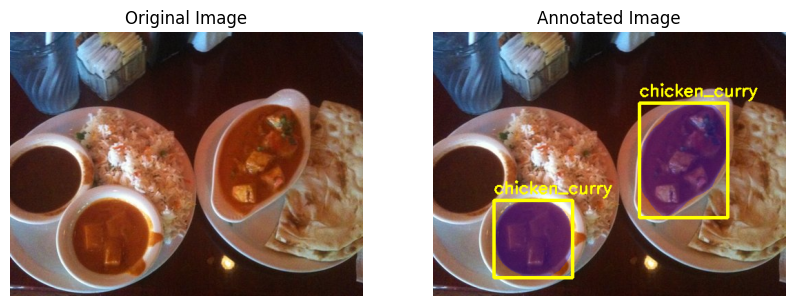

In [9]:
# Reading the Yolo annotation
with open('raw_data/annot_data/demo.txt', 'r') as f:
    demo_annot = f.read().split('\n')
    demo_annot = [i.split(' ') for i in demo_annot]
    demo_annot = [[float(j) for j in i] for i in demo_annot[:-1]]

# Denormalizing the yolo annotation
demo_annot_list = []
for list in demo_annot:
    annot_list = []
    for i, v in enumerate(list[1:]):
        if i%2 == 0:
            annot_list.append(int(v * W))
        else:
            annot_list.append(int(v * H))
    demo_annot_list.append(annot_list)

# Converting the annot list into contours format
demo_annot_cont = tuple(np.asarray([i]).reshape(-1, 1, 2) for i in demo_annot_list)

# Getting the bounding box coords
demo_annot_box = []
for i in demo_annot_cont:
    demo_annot_box.append(cv2.boundingRect(i)) 

# Visualizing the annotation on the image
img = cv2.imread(demo_img_file)
img_cp = img.copy()

# Drawing the contours and filling the polygon
cv2.drawContours(img, demo_annot_cont, -1, (255, 0, 0), -1)
filled = cv2.addWeighted(img, 0.3, img_cp, 1-0.3, 0)

# Drawing the bounding box and text
class_idx = [i[0] for i in demo_annot]
for e, i in enumerate(demo_annot_box):
    x, y, w, h = i
    cv2.rectangle(filled, (x, y), (x+w, y+h), (0, 255, 255), 3)
    cv2.putText(filled, classes5_list[int(class_idx[e])], (x, y-10 if y-10>0 else y+15), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2)
    
# Ploting both the images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_cp, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis(False)
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(filled, cv2.COLOR_BGR2RGB))
plt.title('Annotated Image')
plt.axis(False);

### Creating Yolo Dataset

In [10]:
# Creating functions to handle the conversion
def mask_to_yolo(src_filepath: str, dst_filepath: str, class_list: list, verbose: int = 0):
    """
    """
    # Reading the mask annotation file
    mask = cv2.imread(src_filepath, cv2.IMREAD_GRAYSCALE)
    _, mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)
    H, W = mask.shape

    # Getting the contours of the mask image
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Normalizing the contours
    polygons = []
    for cnt in contours:
        if cv2.contourArea(cnt) > 200:
            polygon = []
            for point in cnt:
                x, y = point[0]
                polygon.append(x / W)
                polygon.append(y / H)
            polygons.append(polygon)
    
    # Getting the class of the annotation
    class_idx = class_list.index(src_filepath.split('/')[-2])
    
    # Creating a file in yolo format and writing all the annotations
    with open(dst_filepath, 'w') as file:
        for polygon in polygons:
            for i, p in enumerate(polygon):
                if i == 0:
                    file.write(f'{class_idx} {p} ')
                elif i == len(polygon) - 1:
                    file.write(f'{p}\n')
                else:
                    file.write(f'{p} ')
    file.close()
    if verbose == 1:
        print(f'[INFO] Mask file is been converted into Yolo format: "{dst_filepath}".')

In [21]:
# Creating a function to create yolo annotation
def create_yolo_labels(src_root_dir: str, dst_root_dir: str, class_list: list, verbose: int = 0):
    """
    """
    # Getting all the mask files path
    for classes in tqdm(os.listdir(src_root_dir)):
        class_path = os.path.join(src_root_dir, classes)
        filepath = [os.path.join(class_path, i ) for i in os.listdir(class_path) if '.ipynb_checkpoints' not in i]

        # Creating the destination directory
        dst_dir = os.path.join(dst_root_dir, classes)
        if not os.path.exists(dst_dir):
            os.makedirs(dst_dir)
        
        # Creating Yolo format annotation file for every mask file
        for file in tqdm(filepath, desc=classes):
            mask_to_yolo(src_filepath=file,
                         dst_filepath=os.path.join(dst_dir, file.split('/')[-1].replace('.png', '.txt')),
                         class_list=class_list,
                         verbose=verbose)
    print('[INFO] All the mask files are converted into Yolo format.')

In [90]:
# Plotting the Yolo annotation
def plot_yolo_segment(img_filepath: str, annot_filepath: str, class_list: list):
    """
    """
    # Reading the image file
    img = cv2.imread(img_filepath)
    H, W, _ = img.shape
    
    # Reading the Yolo annotation
    with open(annot_filepath, 'r') as file:
        norm_annot = file.read().split('\n')
        norm_annot = [i.split(' ') for i in norm_annot]
        norm_annot = [[float(j) for j in i] for i in norm_annot[:-1]] # Last list is empty
    
    # Denormalizing the yolo annotation
    denorm_annot = []
    for annot in norm_annot:
        annot_list = []
        for i, v in enumerate(annot[1:]):
            if i%2 == 0:
                annot_list.append(int(v * W))
            else:
                annot_list.append(int(v * H))
        denorm_annot.append(annot_list)
        
    # Converting the annot list into contours format
    denorm_annot_cont = tuple(np.asarray([i]).reshape(-1, 1, 2) for i in denorm_annot)
    
    # Getting the bounding box coords
    annot_box = []
    for i in denorm_annot_cont:
        annot_box.append(cv2.boundingRect(i))
    
    # Visualizing the annotation on the image
    img_cp = img.copy()
    cv2.drawContours(img, denorm_annot_cont, -1, (255, 0, 0), -1)
    filled = cv2.addWeighted(img, 0.3, img_cp, 1-0.3, 0)
    
    # Drawing the bounding box and text
    class_idx = [int(i[0]) for i in norm_annot]
    for i, box in enumerate(annot_box):
        x, y, w, h = box
        cv2.rectangle(filled, (x, y), (x+w, y+h), (0, 255, 255), 3)
        cv2.putText(filled, class_list[class_idx[i]], (x, y-10 if y-10>10 else y+15), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2)
    
    # Ploting both the images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img_cp, cv2.COLOR_BGR2RGB))
    plt.title(f'Original Image')
    plt.axis(False)
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(filled, cv2.COLOR_BGR2RGB))
    plt.title(f'Annotated Image')
    plt.axis(False);

In [23]:
train_mask_dirpath = 'raw_data/annot_data/5classes_10percent/SegmentationClass/train'
val_mask_dirpath = 'raw_data/annot_data/5classes_10percent/SegmentationClass/val'
train_yolo_label_dirpath = 'datasets/labels/train'
val_yolo_label_dirpath = 'datasets/labels/val'

In [24]:
# Creating train yolo labels
create_yolo_labels(src_root_dir=train_mask_dirpath,
                   dst_root_dir=train_yolo_label_dirpath,
                   class_list=classes5_list,
                   verbose=0)

  0%|          | 0/5 [00:00<?, ?it/s]

chicken_curry:   0%|          | 0/67 [00:00<?, ?it/s]

ramen:   0%|          | 0/72 [00:00<?, ?it/s]

hamburger:   0%|          | 0/58 [00:00<?, ?it/s]

pizza:   0%|          | 0/67 [00:00<?, ?it/s]

chocolate_cake:   0%|          | 0/70 [00:00<?, ?it/s]

[INFO] All the mask files are converted into Yolo format.


In [25]:
# Creating val yolo labels
create_yolo_labels(src_root_dir=val_mask_dirpath,
                   dst_root_dir=val_yolo_label_dirpath,
                   class_list=classes5_list,
                   verbose=0)

  0%|          | 0/5 [00:00<?, ?it/s]

chicken_curry:   0%|          | 0/24 [00:00<?, ?it/s]

ramen:   0%|          | 0/25 [00:00<?, ?it/s]

hamburger:   0%|          | 0/23 [00:00<?, ?it/s]

pizza:   0%|          | 0/25 [00:00<?, ?it/s]

chocolate_cake:   0%|          | 0/24 [00:00<?, ?it/s]

[INFO] All the mask files are converted into Yolo format.


In [27]:
train_yolo_img_dirpath = 'datasets/images/train'
val_yolo_img_dirpath = 'datasets/images/val'
train_img_dirpath = 'raw_data/annot_data/5classes_10percent/JPEGImages/train'
val_img_dirpath = 'raw_data/annot_data/5classes_10percent/JPEGImages/val'

In [33]:
# Moving all the images in the yolo training directory
if not os.path.exists(train_yolo_img_dirpath):
    os.makedirs(train_yolo_img_dirpath)
for dir in os.listdir(train_img_dirpath):
    path = os.path.join(train_img_dirpath, dir)
    shutil.move(src=path, dst=train_yolo_img_dirpath)
print('[INFO] All the files from training directory is moved to yolo datasets directory.')

[INFO] All the training directory is moved to yolo datasets directory.


In [34]:
# Moving all the images in the yolo validation directory
if not os.path.exists(val_yolo_img_dirpath):
    os.makedirs(val_yolo_img_dirpath)
for dir in os.listdir(val_img_dirpath):
    path = os.path.join(val_img_dirpath, dir)
    shutil.move(src=path, dst=val_yolo_img_dirpath)
print('[INFO] All the files from validation directory is moved to yolo datasets directory.')

[INFO] All the files from validation directory is moved to yolo datasets directory.


In [69]:
# Walking through the Yolo datasets
for dirpath, dirnames, filenames in os.walk('datasets'):
    print(f'There are {len(dirnames)} directories and {len(filenames)} images in "{dirpath}".')

There are 2 directories and 0 images in "datasets".
There are 2 directories and 0 images in "datasets/labels".
There are 5 directories and 0 images in "datasets/labels/train".
There are 0 directories and 67 images in "datasets/labels/train/chicken_curry".
There are 0 directories and 72 images in "datasets/labels/train/ramen".
There are 0 directories and 58 images in "datasets/labels/train/hamburger".
There are 0 directories and 67 images in "datasets/labels/train/pizza".
There are 0 directories and 70 images in "datasets/labels/train/chocolate_cake".
There are 5 directories and 0 images in "datasets/labels/val".
There are 0 directories and 24 images in "datasets/labels/val/chicken_curry".
There are 0 directories and 25 images in "datasets/labels/val/ramen".
There are 0 directories and 23 images in "datasets/labels/val/hamburger".
There are 0 directories and 25 images in "datasets/labels/val/pizza".
There are 0 directories and 24 images in "datasets/labels/val/chocolate_cake".
There are

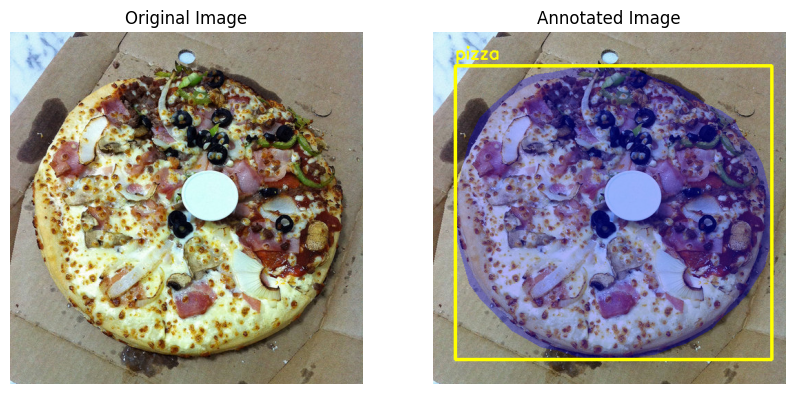

In [99]:
# Randomly visualizing any data in the yolo dataset directory
yolo_images = 'datasets/images/*/*/*'
yolo_img_list = glob.glob(yolo_images)
rand_img = random.sample(yolo_img_list, 1)[0]
plot_yolo_segment(img_filepath=rand_img,
                  annot_filepath=rand_img.replace('images', 'labels').replace('.jpg', '.txt'),
                  class_list=classes5_list)